# This notebooks aims to compare a CNN model trained from scratch to a fine-tuned pretrained model for a similar task

In [14]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import time
import copy
from torch.utils.data import DataLoader
from typing import Tuple
import pandas as pd

In [2]:
# Load the CIFAR-10 dataset
def load_cifar10(batch_size=4):
    """
    Loads the CIFAR-10 dataset and returns the trainloader, testloader, and classes.

    Args:
        batch_size (int): The batch size for the data loaders. Default is 4.

    Returns:
        trainloader (torch.utils.data.DataLoader): The data loader for the training set.
        testloader (torch.utils.data.DataLoader): The data loader for the test set.
        classes (tuple): A tuple containing the class labels for CIFAR-10 dataset.
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = torchvision.datasets.CIFAR10(
        root="../data", train=True, download=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.CIFAR10(
        root="../data", train=False, download=True, transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    # print one image for each class

    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(trainloader.dataset.data[trainloader.dataset.targets.index(i)])
        plt.xlabel(classes[i])
    plt.show()

    return trainloader, testloader, classes

Files already downloaded and verified
Files already downloaded and verified


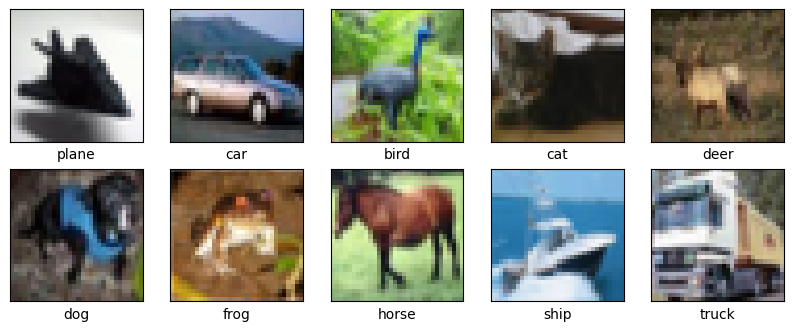

In [3]:
trainloader, testloader, classes = load_cifar10()

num_classes = len(classes)

In [4]:
# get a balanced subset of the CIFAR-10 dataset


def get_balanced_subset(
    trainloader: DataLoader, num_classes: int, num_samples_per_class: int
) -> DataLoader:
    """
    Get a balanced subset of the CIFAR-10 dataset
    """
    # create a list of indices for each class
    indices = [[] for _ in range(num_classes)]
    for i, (_, label) in enumerate(trainloader.dataset):
        if len(indices[label]) < num_samples_per_class:
            indices[label].append(i)
        if all(len(idcs) == num_samples_per_class for idcs in indices):
            break

    # create a new dataset using the indices
    subset = torch.utils.data.Subset(trainloader.dataset, np.concatenate(indices))
    return torch.utils.data.DataLoader(
        subset,
        batch_size=trainloader.batch_size,
        shuffle=True,
        num_workers=trainloader.num_workers,
    )

In [5]:
sub_trainloader = get_balanced_subset(trainloader, num_classes, 500)
sub_testloader = get_balanced_subset(testloader, num_classes, 100)

# Load a pretrained resnet model on Imagenet

In [6]:
# Load pre-trained, for ImageNet, ResNet small model

model = models.resnet18(pretrained=True)

# create a model from scratch

model_scratch = models.resnet18(pretrained=False)

# fine-tune a pre-trained model but only the last layer

model_last_layer = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# freeze all layers except the last one

for param in model_last_layer.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_last_layer.fc.in_features
model_last_layer.fc = nn.Linear(num_ftrs, num_classes)

# Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = torch.optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_last_layer = torch.optim.SGD(
    model_last_layer.parameters(), lr=0.001, momentum=0.9
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
 

In [7]:
print(model_scratch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Our actual architecture is for 1000 classes prediction, let's change this for our 10 classes problem

In [8]:
# replace last layer with a new one

model_scratch.fc = nn.Linear(num_ftrs, num_classes)

model.fc = nn.Linear(num_ftrs, num_classes)

# train & test functions

In [9]:
def train_model(
    model: torch.nn.Module,
    dataloader: DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 5,
    device: str = "cpu",
) -> torch.nn.Module:
    """
    Trains a given model using the provided data and hyperparameters.

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (DataLoader): The data loader containing the training and validation data.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model's parameters.
        num_epochs (int, optional): The number of epochs to train the model (default: 5).
        device (str, optional): The device to run the training on (default: "cpu").

    Returns:
        torch.nn.Module: The trained model.

    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


def test_model(
    model: torch.nn.Module, dataloader: DataLoader, device: str = "cpu"
) -> Tuple[float, float]:
    """
    Test the performance of a model on a given dataloader.

    Args:
        model (torch.nn.Module): The model to be tested.
        dataloader (DataLoader): The dataloader containing the test data.
        device (str, optional): The device to run the model on. Defaults to "cpu".

    Returns:
        Tuple[float, float]: A tuple containing the accuracy and average inference time per sample.
    """
    start = time.time()
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    acc = running_corrects.double() / len(dataloader.dataset)
    end = time.time() - start
    return acc, end / len(dataloader.dataset)

# 5 epochs

In [10]:
model = train_model(
    model,
    {"train": sub_trainloader, "val": sub_testloader},
    criterion,
    optimizer,
    num_epochs=5,
    device=device,
)

Epoch 0/4
----------


train Loss: 2.2000 Acc: 0.2330
val Loss: 1.8201 Acc: 0.3740

Epoch 1/4
----------
train Loss: 1.9148 Acc: 0.3116
val Loss: 1.6241 Acc: 0.4210

Epoch 2/4
----------
train Loss: 1.7847 Acc: 0.3760
val Loss: 1.5611 Acc: 0.4900

Epoch 3/4
----------
train Loss: 1.6812 Acc: 0.4166
val Loss: 1.5340 Acc: 0.5230

Epoch 4/4
----------
train Loss: 1.6237 Acc: 0.4458
val Loss: 1.5110 Acc: 0.5000

Training complete in 22m 49s
Best val Acc: 0.5230


In [11]:
model_scratch = train_model(
    model_scratch,
    {"train": sub_trainloader, "val": sub_testloader},
    criterion,
    optimizer_scratch,
    num_epochs=5,
    device=device,
)

Epoch 0/4
----------


train Loss: 2.1569 Acc: 0.2066
val Loss: 1.9412 Acc: 0.3020

Epoch 1/4
----------
train Loss: 1.9506 Acc: 0.2964
val Loss: 1.7993 Acc: 0.3380

Epoch 2/4
----------
train Loss: 1.8285 Acc: 0.3466
val Loss: 1.6733 Acc: 0.4070

Epoch 3/4
----------
train Loss: 1.7552 Acc: 0.3740
val Loss: 1.6419 Acc: 0.4270

Epoch 4/4
----------
train Loss: 1.6508 Acc: 0.4126
val Loss: 1.5270 Acc: 0.4700

Training complete in 22m 18s
Best val Acc: 0.4700


In [12]:
model_last_layer = train_model(
    model_last_layer,
    {"train": sub_trainloader, "val": sub_testloader},
    criterion,
    optimizer_last_layer,
    num_epochs=5,
    device=device,
)

Epoch 0/4
----------
train Loss: 2.5488 Acc: 0.2346
val Loss: 3.6096 Acc: 0.2640

Epoch 1/4
----------
train Loss: 2.5668 Acc: 0.2562
val Loss: 3.8266 Acc: 0.2500

Epoch 2/4
----------
train Loss: 2.5726 Acc: 0.2678
val Loss: 4.3412 Acc: 0.2420

Epoch 3/4
----------
train Loss: 2.6132 Acc: 0.2558
val Loss: 4.1331 Acc: 0.2780

Epoch 4/4
----------
train Loss: 2.5819 Acc: 0.2646
val Loss: 3.8768 Acc: 0.2860

Training complete in 6m 33s
Best val Acc: 0.2860


In [13]:
acc, time_per_sample = test_model(model, testloader, device)

acc_scratch, time_per_sample_scratch = test_model(model_scratch, testloader, device)

acc_last_layer, time_per_sample_last_layer = test_model(
    model_last_layer, testloader, device
)

In [16]:
results = pd.DataFrame(
    {
        "model": ["pre-trained", "from scratch", "last layer"],
        "accuracy": [acc, acc_scratch, acc_last_layer],
        "time per sample": [
            time_per_sample,
            time_per_sample_scratch,
            time_per_sample_last_layer,
        ],
    }
)

print(results)

          model                             accuracy  time per sample
0   pre-trained  tensor(0.5169, dtype=torch.float64)         0.008049
1  from scratch  tensor(0.4529, dtype=torch.float64)         0.007522
2    last layer  tensor(0.2818, dtype=torch.float64)         0.008894


# Obviously the inference time is very similar because they all have the same architecture, however training the last-layer one is significantly quicker as we only update a small part of the network but the results are pretty bad.

# An interesting results is that for the same number of epochs using the pretrained model for a similar task got a better result at the end. Using this information we could think of faster training time for specific models using pre-existing weights for similar tasks.